Importation of all the libraries required for this notebook.

In [13]:
!pip install plot-keras-history

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import json
import cv2
import time
import random

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.applications import VGG16
from plot_keras_history import show_history, plot_history

In [15]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

numpy - 1.23.5
json - 2.0.9
cv2 - 4.8.0


For Google Colaboratory (deactivate by commenting if you are on your local machine).

In [16]:
# For Google Colaboratory
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [17]:
%cd '/content/gdrive/MyDrive/Master Ingénieur IA [OC]/Slides Projets/Projet #8/'

/content/gdrive/MyDrive/Master Ingénieur IA [OC]/Slides Projets/Projet #8


---

In [18]:
class ImageDataGenerator(Sequence):
    def __init__(self, image_files, mask_files, resize, batch_size, augment=False):
        self.image_files = image_files
        self.mask_files = mask_files
        self.resize = resize
        self.batch_size = batch_size
        self.augment = augment
        if self.augment:
            self.aug = iaa.Sequential([
                iaa.Fliplr(0.4),
                iaa.Flipud(0.4),
                iaa.Affine(scale=(0.8, 1.2)),
                iaa.AdditiveGaussianNoise(scale=0.05*255)
            ])

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        imgs = []
        masks = []
        for img_file, mask_file in zip(batch_x, batch_y):
            img = cv2.imread(img_file)
            img = cv2.resize(img, (self.resize, self.resize))
            img = img / 255.0
            img = img.astype('float32')

            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (self.resize, self.resize))
            mask = self.color_to_class(mask)

            if self.augment:
                img, mask = self.aug.augment_images([img, mask])

            imgs.append(img)
            masks.append(mask)

        return np.array(imgs), np.array(masks)

    def color_to_class(self, mask):
        color_dict = {
            'flat': [214, 112, 218],
            'human': [0, 0, 255],
            'vehicle': [255, 0, 0],
            'construction': [105, 105, 105],
            'object': [0, 215, 255],
            'nature': [50, 205, 50],
            'sky': [235, 206, 135],
            'void': [0, 0, 0]
        }
        class_dict = {k: v for v, k in enumerate(color_dict.keys())}
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for class_name, color in color_dict.items():
            mask_class[np.where((mask == color).all(axis=-1))] = class_dict[class_name]
        mask_class = mask_class.astype('int')
        return to_categorical(mask_class, num_classes=len(class_dict))

In [19]:
# Using the ImageDataGenerator class
image_dir = 'data/images'
mask_dir = 'data/masks'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

# Ensure the same order for image and mask files
image_files.sort()
mask_files.sort()

# Pairing image and mask files
paired_files = list(zip(image_files, mask_files))

# Shuffling the data
random.shuffle(paired_files)

# Selecting a subset of data
paired_files = paired_files[:900]

# Separation into training, validation and test sets
train_files = paired_files[:500]
val_files = paired_files[500:700]
test_files = paired_files[700:900]

# Unzipping the pairs
train_image_files, train_mask_files = zip(*train_files)
val_image_files, val_mask_files = zip(*val_files)
test_image_files, test_mask_files = zip(*test_files)

# Creation of generators
train_generator = ImageDataGenerator(train_image_files, train_mask_files, 256, 4)
val_generator = ImageDataGenerator(val_image_files, val_mask_files, 256, 4)
test_generator = ImageDataGenerator(test_image_files, test_mask_files, 256, 4)

---

In [27]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

----

# **Model**  

In [21]:
def segnet_vgg16(input_shape=(256, 256, 3), num_classes=8):
    # Load pre-trained VGG16 model as encoder
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Retrieve outputs from layers of interest
    conv1 = vgg16.get_layer('block1_conv2').output
    conv2 = vgg16.get_layer('block2_conv2').output
    conv3 = vgg16.get_layer('block3_conv3').output
    conv4 = vgg16.get_layer('block4_conv3').output
    conv5 = vgg16.get_layer('block5_conv3').output

    # Create the decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)

    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=vgg16.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

    return model

In [22]:
# Create the template
model_segnet_vgg16 = segnet_vgg16(input_shape=(256, 256, 3), num_classes=8)

In [23]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_dice_coef', patience=3, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_final_model.h5', monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)

In [24]:
start_time = time.time()

# Train the model
history_segnet_vgg16 = model_segnet_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint],
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_final_segnet_vgg16 = end_time - start_time
print(f"Training time: {training_final_segnet_vgg16} seconds")

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.8360 - dice_coef: 0.6257
Epoch 1: val_dice_coef improved from -inf to 0.65277, saving model to best_final_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 1700s 13s/step - loss: 0.8360 - dice_coef: 0.6257 - val_loss: 1.4121 - val_dice_coef: 0.6528
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.6243 - dice_coef: 0.7145
Epoch 2: val_dice_coef did not improve from 0.65277
125/125 [==============================] - 103s 823ms/step - loss: 0.6243 - dice_coef: 0.7145 - val_loss: 1.1304 - val_dice_coef: 0.6422
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.5597 - dice_coef: 0.7425
Epoch 3: val_dice_coef improved from 0.65277 to 0.67760, saving model to best_final_model.h5
125/125 [==============================] - 106s 851ms/step - loss: 0.5597 - dice_coef: 0.7425 - val_loss: 0.6961 - val_dice_coef: 0.6776
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.5183 - dice_coef: 0.7607
Epoch 4: val_dice_coef improved from 0.67760 to 0.75690, saving model to best_final_model.h5
125/125 [==============================] - 106s 844ms/step - 

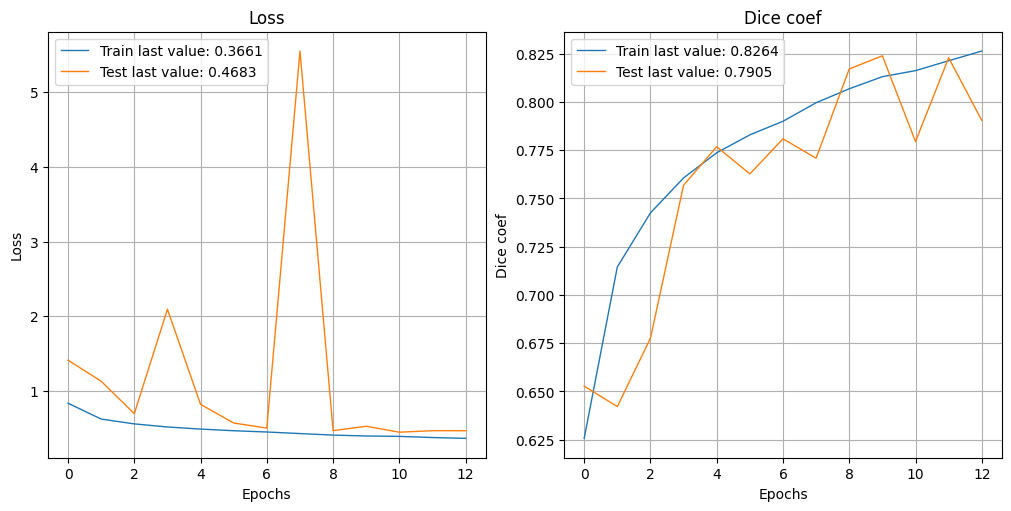

In [25]:
show_history(history_segnet_vgg16)
plot_history(history_segnet_vgg16, path="history_final_segnet_vgg16.png")
plt.close()

In [32]:
# Load the best model
model_segnet_vgg16 = load_model('best_final_model.h5', custom_objects={'dice_coef': dice_coef})

# Evaluate the model
loss_segnet_vgg16, dice_coef_segnet_vgg16 = model_segnet_vgg16.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_segnet_vgg16))
print('Dice Coefficient of Final Segnet_Vgg16: {:.2f}'.format(dice_coef_segnet_vgg16))

30/30 [==============================] - 289s 10s/step - loss: 0.5018 - dice_coef: 0.8312
Loss: 0.50
Dice Coefficient of Final Segnet_Vgg16: 0.83
